In [2]:
!pip install -q tflite-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 14.0 MB/s eta 0:0

In [3]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [4]:
dataset_is_split = True #@param ["False", "True"] {type:"raw"}

In [5]:
# The ZIP file you uploaded:
!unzip dataset.zip

# Your labels map as a dictionary (zero is reserved):
label_map = {1: 'Basketball'} 

if dataset_is_split:
  # If your dataset is already split, specify each path:
  train_images_dir = 'train/images'
  train_annotations_dir = 'train/annotations'
  val_images_dir = 'valid/images'
  val_annotations_dir = 'valid/annotations'
  test_images_dir = 'test/images'
  test_annotations_dir = 'test/annotations'
else:
  # If it's NOT split yet, specify the path to all images and annotations
  images_in = 'images'
  annotations_in = 'annotations'
  

Archive:  dataset.zip
   creating: test/annotations/
  inflating: test/annotations/video_4_20230223-103145-mp4_frame13_jpg.rf.bd438d8ba236777a5fe96ddb5956e999.xml  
  inflating: test/annotations/video_4_20230223-103145-mp4_frame153_jpg.rf.f8b0676fc50111e99c8de9130cd97292.xml  
  inflating: test/annotations/video_4_20230223-103145-mp4_frame163_jpg.rf.bc902fbf3e1df947372057fb2674d9d8.xml  
  inflating: test/annotations/video_4_20230223-103145-mp4_frame165_jpg.rf.63838d7cd2092f5f59dd1a3358c8b622.xml  
  inflating: test/annotations/video_4_20230223-103145-mp4_frame17_jpg.rf.372f5c5297dcaebcead186295eb51b34.xml  
  inflating: test/annotations/video_4_20230223-103145-mp4_frame170_jpg.rf.31dc832ceb6eb39959363cce82100bfa.xml  
  inflating: test/annotations/video_4_20230223-103145-mp4_frame180_jpg.rf.7b6a5926f754cd0d623e0dd73be3f5b4.xml  
  inflating: test/annotations/video_4_20230223-103145-mp4_frame183_jpg.rf.1d5ef0c5e82f254015b1147cf2846b26.xml  
  inflating: test/annotations/video_4_2023022

In [6]:
#@markdown Be sure you run this cell. It's hiding the `split_dataset()` function used in the next code block.

import os
import random
import shutil

def split_dataset(images_path, annotations_path, val_split, test_split, out_path):
  """Splits a directory of sorted images/annotations into training, validation, and test sets.

  Args:
    images_path: Path to the directory with your images (JPGs).
    annotations_path: Path to a directory with your VOC XML annotation files,
      with filenames corresponding to image filenames. This may be the same path
      used for images_path.
    val_split: Fraction of data to reserve for validation (float between 0 and 1).
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  Returns:
    The paths for the split images/annotations (train_dir, val_dir, test_dir)
  """
  _, dirs, _ = next(os.walk(images_path))

  train_dir = os.path.join(out_path, 'train')
  val_dir = os.path.join(out_path, 'validation')
  test_dir = os.path.join(out_path, 'test')

  IMAGES_TRAIN_DIR = os.path.join(train_dir, 'images')
  IMAGES_VAL_DIR = os.path.join(val_dir, 'images')
  IMAGES_TEST_DIR = os.path.join(test_dir, 'images')
  os.makedirs(IMAGES_TRAIN_DIR, exist_ok=True)
  os.makedirs(IMAGES_VAL_DIR, exist_ok=True)
  os.makedirs(IMAGES_TEST_DIR, exist_ok=True)

  ANNOT_TRAIN_DIR = os.path.join(train_dir, 'annotations')
  ANNOT_VAL_DIR = os.path.join(val_dir, 'annotations')
  ANNOT_TEST_DIR = os.path.join(test_dir, 'annotations')
  os.makedirs(ANNOT_TRAIN_DIR, exist_ok=True)
  os.makedirs(ANNOT_VAL_DIR, exist_ok=True)
  os.makedirs(ANNOT_TEST_DIR, exist_ok=True)

  # Get all filenames for this dir, filtered by filetype
  filenames = os.listdir(os.path.join(images_path))
  filenames = [os.path.join(images_path, f) for f in filenames if (f.endswith('.jpg'))]
  # Shuffle the files, deterministically
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Get exact number of images for validation and test; the rest is for training
  val_count = int(len(filenames) * val_split)
  test_count = int(len(filenames) * test_split)
  for i, file in enumerate(filenames):
    source_dir, filename = os.path.split(file)
    annot_file = os.path.join(annotations_path, filename.replace("jpg", "xml"))
    if i < val_count:
      shutil.copy(file, IMAGES_VAL_DIR)
      shutil.copy(annot_file, ANNOT_VAL_DIR)
    elif i < val_count + test_count:
      shutil.copy(file, IMAGES_TEST_DIR)
      shutil.copy(annot_file, ANNOT_TEST_DIR)
    else:
      shutil.copy(file, IMAGES_TRAIN_DIR)
      shutil.copy(annot_file, ANNOT_TRAIN_DIR)
  return (train_dir, val_dir, test_dir)

In [7]:
# We need to instantiate a separate DataLoader for each split dataset
if dataset_is_split:
  train_data = object_detector.DataLoader.from_pascal_voc(
      train_images_dir, train_annotations_dir, label_map=label_map)
  validation_data = object_detector.DataLoader.from_pascal_voc(
      val_images_dir, val_annotations_dir, label_map=label_map)
  test_data = object_detector.DataLoader.from_pascal_voc(
      test_images_dir, test_annotations_dir, label_map=label_map)
else:
  train_dir, val_dir, test_dir = split_dataset(images_in, annotations_in,
                                                val_split=0.2, test_split=0.2,
                                                out_path='split-dataset')
  train_data = object_detector.DataLoader.from_pascal_voc(
      os.path.join(train_dir, 'images'),
      os.path.join(train_dir, 'annotations'), label_map=label_map)
  validation_data = object_detector.DataLoader.from_pascal_voc(
      os.path.join(val_dir, 'images'),
      os.path.join(val_dir, 'annotations'), label_map=label_map)
  test_data = object_detector.DataLoader.from_pascal_voc(
      os.path.join(test_dir, 'images'),
      os.path.join(test_dir, 'annotations'), label_map=label_map)
  
print(f'train count: {len(train_data)}')
print(f'validation count: {len(validation_data)}')
print(f'test count: {len(test_data)}')

train count: 365
validation count: 104
test count: 53


In [8]:
spec = object_detector.EfficientDetLite0Spec()

In [9]:
model = object_detector.create(train_data=train_data, 
                               model_spec=spec, 
                               validation_data=validation_data, 
                               epochs=75, 
                               batch_size=10, 
                               train_whole_model=True)

Epoch 1/75
36/36 [==============================] - 65s 590ms/step - det_loss: 2.0745 - cls_loss: 0.8973 - box_loss: 0.0235 - reg_l2_loss: 0.0630 - loss: 2.1375 - learning_rate: 0.0102 - gradient_norm: 5.9824 - val_det_loss: 1.2811 - val_cls_loss: 0.4660 - val_box_loss: 0.0163 - val_reg_l2_loss: 0.0632 - val_loss: 1.3442
Epoch 2/75
36/36 [==============================] - 16s 438ms/step - det_loss: 1.1330 - cls_loss: 0.4576 - box_loss: 0.0135 - reg_l2_loss: 0.0634 - loss: 1.1964 - learning_rate: 0.0125 - gradient_norm: 6.2990 - val_det_loss: 2.1211 - val_cls_loss: 0.5049 - val_box_loss: 0.0323 - val_reg_l2_loss: 0.0636 - val_loss: 2.1847
Epoch 3/75
36/36 [==============================] - 16s 439ms/step - det_loss: 0.8353 - cls_loss: 0.3863 - box_loss: 0.0090 - reg_l2_loss: 0.0637 - loss: 0.8990 - learning_rate: 0.0125 - gradient_norm: 4.3802 - val_det_loss: 1.4543 - val_cls_loss: 0.3449 - val_box_loss: 0.0222 - val_reg_l2_loss: 0.0638 - val_loss: 1.5181
Epoch 4/75
36/36 [=============

In [10]:
model.evaluate(test_data)

1/1 [==============================] - 10s 10s/step



{'AP': 0.6074407,
 'AP50': 1.0,
 'AP75': 0.6545913,
 'APs': 0.5952186,
 'APm': 0.698865,
 'APl': -1.0,
 'ARmax1': 0.6679245,
 'ARmax10': 0.709434,
 'ARmax100': 0.7169811,
 'ARs': 0.7133333,
 'ARm': 0.7375,
 'ARl': -1.0,
 'AP_/Basketball': 0.6074407}

In [12]:
TFLITE_FILENAME = 'sunny.tflite'
LABELS_FILENAME = 'sunnylabels.txt'

In [13]:
model.export(export_dir='.', tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

In [25]:
model.evaluate_tflite(TFLITE_FILENAME, test_data)

53/53 [==============================] - 152s 3s/step



{'AP': 0.5812961,
 'AP50': 1.0,
 'AP75': 0.5190469,
 'APs': 0.56245136,
 'APm': 0.7030677,
 'APl': -1.0,
 'ARmax1': 0.6528302,
 'ARmax10': 0.65849054,
 'ARmax100': 0.65849054,
 'ARs': 0.64444447,
 'ARm': 0.7375,
 'ARl': -1.0,
 'AP_/Basketball': 0.5812961}

In [34]:
import random

# Taking random image from our dataset
images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
filenames = os.listdir(os.path.join(images_path))
random_index = random.randint(0,len(filenames)-1)
INPUT_IMAGE = os.path.join(images_path, filenames[random_index])

In [ ]:
! python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral

[Object(id=0, score=0.5, bbox=BBox(xmin=166, ymin=258, xmax=179, ymax=282))]


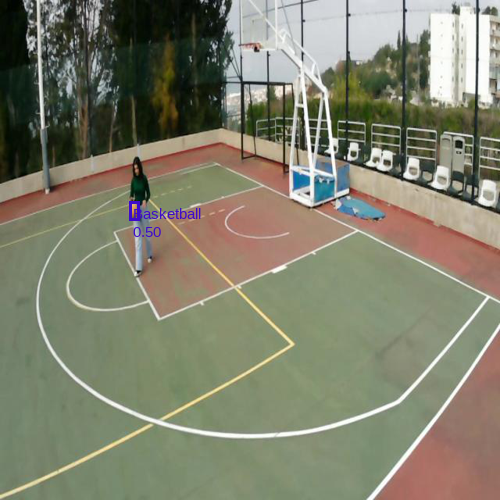

In [40]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size=15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model
labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

# Resize the image for input
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.4, image_scale=scale)

print(objs)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
image

In [39]:
images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
filenames = os.listdir(os.path.join(images_path))

!mkdir outimageeeeeees

for i, filename in enumerate(filenames):
  INPUT_IMAGE = os.path.join(images_path, filename)
  
  # Resize the image for input
  image = Image.open(INPUT_IMAGE)
  _, scale = common.set_resized_input(
      interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

  interpreter.invoke()
  objs = detect.get_objects(interpreter, score_threshold=0.4, image_scale=scale)

  print(objs)

  # Resize again to a reasonable size for display
  display_width = 500
  scale_factor = display_width / image.width
  height_ratio = image.height / image.width
  image = image.resize((display_width, int(display_width * height_ratio)))
  draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
  image

  image.save(f'outimageeeeeees/imagee-{i}.jpg')



[Object(id=0, score=0.484375, bbox=BBox(xmin=306, ymin=246, xmax=316, ymax=266))]
[Object(id=0, score=0.58203125, bbox=BBox(xmin=303, ymin=260, xmax=315, ymax=281))]
[Object(id=0, score=0.53125, bbox=BBox(xmin=302, ymin=242, xmax=313, ymax=261))]
[]
[Object(id=0, score=0.46875, bbox=BBox(xmin=111, ymin=328, xmax=130, ymax=363))]
[Object(id=0, score=0.7265625, bbox=BBox(xmin=181, ymin=265, xmax=194, ymax=288))]
[Object(id=0, score=0.453125, bbox=BBox(xmin=399, ymin=246, xmax=411, ymax=267))]
[Object(id=0, score=0.69921875, bbox=BBox(xmin=332, ymin=314, xmax=347, ymax=341))]
[]
[Object(id=0, score=0.6875, bbox=BBox(xmin=61, ymin=523, xmax=89, ymax=575))]
[Object(id=0, score=0.515625, bbox=BBox(xmin=137, ymin=284, xmax=153, ymax=314))]
[Object(id=0, score=0.53125, bbox=BBox(xmin=360, ymin=258, xmax=375, ymax=285))]
[Object(id=0, score=0.78515625, bbox=BBox(xmin=305, ymin=146, xmax=316, ymax=166))]
[]
[Object(id=0, score=0.5, bbox=BBox(xmin=302, ymin=209, xmax=313, ymax=228))]
[Object(id=0